In [25]:
import sys

lib_dir = "/home/daniele/documents/github/ftt01/phd/share/lib"
sys.path.insert(0, lib_dir)


In [26]:
from lib import *

In [27]:
from zoneinfo import ZoneInfo

def read_timeseries_pd(standard_df, input_dt_format, datetime_col='datetime',
                    output_dt_format=None, from_timezone=None, to_timezone='no'):

    datetime_idx = [ dt.datetime.strptime(col, input_dt_format)  for col in standard_df[datetime_col] ]

    if from_timezone != None:
        if to_timezone == 'no':
            datetime_idx = [idx.replace(tzinfo=ZoneInfo(from_timezone)).replace(
                tzinfo=None) for idx in datetime_idx]
        else:
            datetime_idx = [idx.replace(tzinfo=ZoneInfo(from_timezone)).astimezone(
                tz=ZoneInfo(to_timezone)) for idx in datetime_idx]
    else:
        if to_timezone == 'no':
            datetime_idx = [idx.replace(tzinfo=None) for idx in datetime_idx]
        else:
            datetime_idx = [idx.astimezone(tz=ZoneInfo(
                to_timezone)) for idx in datetime_idx]

    if output_dt_format != None:
        datetime_idx = [dt.datetime.strftime(
            idx, format=output_dt_format) for idx in datetime_idx]

    standard_df[datetime_col] = datetime_idx
    standard_df.set_index( datetime_col, inplace=True )

    return standard_df

In [28]:
wdir = "/media/windows/projects/icon_evaluation/"

variables = ['precipitation', 'temperature']
basin = "passirio"

timezone_str = 'Europe/Rome'

# kriging dates - NB: must be the same of the kriging simulation
start_kr_date_str = '2010-10-01 00:00:00'
end_kr_date_str = '2021-10-17 00:00:00'

start_date = dt.datetime.strptime(start_kr_date_str, '%Y-%m-%d %H:%M:%S')
end_date = dt.datetime.strptime(end_kr_date_str, '%Y-%m-%d %H:%M:%S')

dates = [start_date + dt.timedelta(hours=x)
         for x in range(1, (end_date-start_date).days*24 + 1)]

calibration_lag_hours = 1*360*24
wu_days = 360
da_days = 5
forecasting_lead_time = 24

ensemble_size = 20

meteo_src = "GS"
outlet_points = ["118", "155"]

# kr_corr = 'NO'
# kr_type='OKED'

# points metadata
# the grid is obtained in QGIS from the output.csv and the DTM elevation
points_file = wdir + 'data/forecast/' + 'points3.csv'
points_df = pd.read_csv(points_file)
points_df.set_index('ID', inplace=True)

output_dt_format = '%Y-%m-%d %H:%M:%S'
input_dt_format = '%Y-%m-%d %H:%M:%S'

### KRIGING DATA
Extract the data from the kriging model output and analyze the results

In [29]:
for variable in variables:

    print(variable)

    if variable == 'temperature':
        kr_corr = 'NO'
        kr_type = 'OKED'
    elif variable == 'precipitation':
        kr_corr = 'DEUTSCH'
        kr_type = 'OKED'

    curr_df = pd.DataFrame(dates, columns=['datetime'])

    for g in points_df.index:

        output_weather_data_path = wdir + "hydro_modeling/" + \
            basin + "/meteo/GS/observations/{variable}/"

        grid_weather_data_path = wdir + \
            "kriging/output_passirio_stations_complete/{variable}/KR/{kr_type}/{kr_correction}/"

        internal_id = str(int(g))

        east = str(points_df.loc[g]['lon'])
        north = str(points_df.loc[g]['lat'])
        elevation = str(points_df.loc[g]['elev'])

        current_data_path = grid_weather_data_path.format(
            variable=variable, kr_type=kr_type, kr_correction=kr_corr)
        # print(current_data_path)

        try:
            current_file = glob.glob(
                current_data_path + '*_{id}_*.csv'.format(id=internal_id))[0]
        except IndexError as err:
            print('Missing point: ' + internal_id)
            continue

        current_data = pd.DataFrame(pd.read_csv(current_file)[
                                    internal_id].values, index=dates, columns=[internal_id])
        current_data.index.name = 'datetime'

        # current_data = current_data[start_date:end_date]

        if variable == 'precipitation':
            current_data = current_data.resample('h').sum()
            current_data.reset_index(inplace=True)
            curr_df = curr_df.merge(current_data, on='datetime')
        elif variable == 'temperature':
            current_data = current_data.resample('h').mean()
            current_data.reset_index(inplace=True)
            curr_df = curr_df.merge(current_data, on='datetime')
        else:
            print('NOT A VALID VARIABLE!')
            continue

    if variable == 'precipitation':
        precipitation_data_kr = curr_df
        precipitation_data_kr.set_index('datetime', inplace=True)
    elif variable == 'temperature':
        temperature_data_kr = curr_df
        temperature_data_kr.set_index('datetime', inplace=True)

    del [curr_df, current_data]


precipitation
Missing point: 52
Missing point: 137
Missing point: 168
Missing point: 214
Missing point: 238
temperature
Missing point: 52
Missing point: 137
Missing point: 168
Missing point: 214
Missing point: 238


### FORECAST DATA
Extract the data from the forecasting model output and analyze the results.

The extraction creates a DF of points as index and dates as columns, each cell contains the N-array of forecast hours (e.g. 24 hours).
The bias dataframe of TEMPERATURE is created with points as index and lead hours as columns.

In [30]:
# forecasting dates
start_date_str = '2021-06-15 00:00:00'
end_date_str = '2021-10-17 00:00:00'

start_date = dt.datetime.strptime(start_date_str, '%Y-%m-%d %H:%M:%S')
end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d %H:%M:%S')

dates = [start_date + dt.timedelta(days=x)
         for x in range((end_date-start_date).days)]

In [31]:
for variable in variables:
    input_fct_path = wdir + 'data/forecast/icon_d2_eps_45h/postprocessed/' + \
        basin + '/' + variable + '/deterministic/mean/{YYYYmmdd}/'

    fct_df = pd.DataFrame()
    for date in dates:

        date_str = dt.datetime.strftime(date, '%Y%m%d')
        curr_fct_path = input_fct_path.format(YYYYmmdd=date_str)

        if not( os.path.exists(curr_fct_path) ):
            # print(curr_fct_path)
            continue

        id_points = [str(i) for i in points_df.index]
        current_fct = pd.DataFrame(index=id_points)

        fct_array = []
        for id_point in id_points:

            df = read_timeseries_pd(pd.read_csv(curr_fct_path +
                id_point + '.csv', sep=';'), '%Y-%m-%d %H:%M:%S')
            df = df.rename(columns={'values': id_point})
            df = df.iloc[-forecasting_lead_time:]

            fct_values = df[id_point].values
            fct_array.append([round(f, 2) for f in fct_values])

        current_fct[date_str] = fct_array

        if fct_df.empty:
            fct_df = current_fct
        else:
            fct_df = pd.merge(fct_df, current_fct,
                              left_index=True, right_index=True)

    if variable == 'precipitation':
        precipitation_data_fct = fct_df.T
    elif variable == 'temperature':
        temperature_data_fct = fct_df.T
    else:
        print('NOT A VALID VARIABLE!')

    del [fct_df]

Extraction of the temperature bias as table [ x:points, y:forecasting_dates, z:"array of each hour in the lead time" ] and as mean 
over the lead time hour over the entire period [ x:points, y:lead_hours, z:bias]

In [32]:
variable = 'temperature'
    
input_fct_path = wdir + 'data/forecast/icon_d2_eps_45h/postprocessed/' + \
    basin + '/' + variable + '/deterministic/mean/{YYYYmmdd}/'

bias_table = pd.DataFrame()
for date in dates:

    date_str = dt.datetime.strftime(date, '%Y%m%d')
    curr_fct_path = input_fct_path.format(YYYYmmdd=date_str)

    if not( os.path.exists(curr_fct_path) ):
        # print(curr_fct_path)
        continue

    id_points = [str(i) for i in points_df.index]
    current_bias = pd.DataFrame(index=id_points)

    bias_array = []
    for id_point in id_points:

        df = read_timeseries_pd(pd.read_csv(curr_fct_path +
            id_point + '.csv', sep=';'), '%Y-%m-%d %H:%M:%S')
        df = df.rename(columns={'values': id_point})
        df = df.iloc[-forecasting_lead_time:]

        fct_values = df[id_point].values
        fct_array.append([round(f, 2) for f in fct_values])

        try:
            if variable == 'precipitation':
                obs_data = precipitation_data_kr[[id_point]]
            elif variable == 'temperature':
                obs_data = temperature_data_kr[[id_point]]
        except:
            # current_bias.drop(id_point)
            current_fct.drop(id_point)

        obs_values = np.array(
            [float(obs_data.loc[dt.datetime.strftime(i, output_dt_format)]) for i in df.index])
        
        bias = obs_values - fct_values
        bias = [round(b, 2) for b in bias]
        bias_array.append(bias)

    current_bias[date_str] = bias_array

    if bias_table.empty:
        bias_table = current_bias
    else:
        bias_table = pd.merge(bias_table, current_bias,
                                left_index=True, right_index=True)

bias_on_24_df = pd.DataFrame(
    index=bias_table.index, columns=range(1, forecasting_lead_time+1))

for point in bias_table.index:
    # print(point)

    for date in bias_table.columns:
        # print(bias_table.loc[point][date])

        for c in range(forecasting_lead_time):
            try:
                bias_on_24_df.loc[point][c +
                                            1].append(bias_table.loc[point][date][c])
            except AttributeError as err:
                bias_on_24_df.loc[point][c +
                                            1] = [bias_table.loc[point][date][c]]
            except:
                raise

bias_on_24_mean_df = pd.DataFrame(
    index=bias_table.index, columns=bias_on_24_df.columns)

for point in bias_on_24_df.index:
    # print(point)

    for hour in bias_on_24_df.columns:
        # print(hour)

        daily_bias_array = bias_on_24_df.loc[point][hour]
        bias_on_24_mean_df.loc[point][hour] = round(
            np.mean(daily_bias_array), 2)

temperature_data_fct_bias = bias_on_24_mean_df

#### IAHR analysis

In [33]:
output_path_iahr22 = wdir + 'iahr2022_bis/'
mkNestedDir(output_path_iahr22)

In [34]:
# temporal mean bias of TEMPERATURE for each point
temporal_mean_bias_fct_kr_hourly = pd.DataFrame(
    temperature_data_fct_bias.mean(axis=1), columns=['bias'])
temporal_mean_bias_fct_kr_hourly.index.name = 'points'

east_array = []
north_array = []
elevation_array = []

for g in temporal_mean_bias_fct_kr_hourly.index:

    east_array.append( str(points_df.loc[int(g)]['lon']) )
    north_array.append( str(points_df.loc[int(g)]['lat']) )
    elevation_array.append( str(points_df.loc[int(g)]['elev']) )

temporal_mean_bias_fct_kr_hourly['lon'] = east_array
temporal_mean_bias_fct_kr_hourly['lat'] = north_array
temporal_mean_bias_fct_kr_hourly['elev'] = elevation_array

temporal_mean_bias_fct_kr_hourly.to_csv(
    output_path_iahr22 + 'temperature_temporal_mean_bias_fct_kr_hourly.csv')

In [35]:
# spatial mean bias of TEMPERATURE over the 24 hours
temperature_data_kr_cut = temperature_data_kr[start_date_str:end_date_str]

temperature_spatial_mean_bias_df = pd.DataFrame(
    index=temperature_data_kr_cut.index, columns=['bias'])
temperature_spatial_mean_bias = []

for date in temperature_data_kr_cut.index:

    date_str = dt.datetime.strftime(date, '%Y%m%d')

    try:
        current_forecast_data = temperature_data_fct.T[[date_str]]
    except KeyError as e:
        # print("Not forecasted day: " + date_str)
        temperature_spatial_mean_bias_df = temperature_spatial_mean_bias_df.drop(
            date)
        continue

    # array of all points data at this time and hour
    kr_array = []
    fct_array = []

    for point in current_forecast_data.index:
        # print(point)

        try:
            kr_array.append(temperature_data_kr_cut.loc[dt.datetime.strftime(
                date + dt.timedelta(hours=date.hour), input_dt_format)][point])
            fct_array.append(current_forecast_data.loc[point][0][date.hour])
        except KeyError as e:
            continue

    temperature_spatial_mean_bias.append(
        np.mean([fct_array[n] - kr_array[n] for n in range(len(fct_array))]))

temperature_spatial_mean_bias_df['bias'] = temperature_spatial_mean_bias
temperature_spatial_mean_bias_df.index.name = 'datetime'
temperature_spatial_mean_bias_df.to_csv(
    output_path_iahr22 + 'temperature_spatial_mean_bias.csv')

createBoxPlot(temperature_spatial_mean_bias_df['bias'], "Time $[hour]$", "Temperature bias $[\degree C]$",
              output_file=output_path_iahr22 + 'boxplot_spatial_mean_temperature_bias.' + output_format, period='H',
              output_format=output_format, my_dpi=600)

In [36]:
# scatter plot of TEMPERATURE bias over all the points considered in the basin

import hvplot.pandas
points_list = temperature_data_fct_bias.columns.to_list()
points_list = points_list[1:]
# try:
#     temperature_data_fct_bias_unidx = temperature_data_fct_bias.reset_index()
# except:
#     temperature_data_fct_bias_unidx = temperature_data_fct_bias

temperature_data_fct_bias.plot(
    kind='scatter', x=temperature_data_fct_bias.index, y=points_list, backend='plotly')

In [37]:
# spatial mean bias of PRECIPITATION over the 24 hours
precipitation_data_kr_cut = precipitation_data_kr[start_date_str:end_date_str]

precipitation_cumulative = pd.DataFrame(
    index=precipitation_data_fct.columns, columns=['fct','kr'])

fct_array = []
kr_array = []

for point in precipitation_data_fct.columns:

    summa = 0.00
    for date in precipitation_data_fct.index:
        summa = summa + np.sum(precipitation_data_fct.T.loc[point][date])
    fct_array.append(summa)
    
    try:
        kr_array.append(precipitation_data_kr_cut[str(point)].sum())
    except:
        kr_array.append(np.nan)

precipitation_cumulative['fct'] = fct_array
precipitation_cumulative['kr'] = kr_array

precipitation_cumulative['bias'] = precipitation_cumulative['fct'] - \
    precipitation_cumulative['kr']
precipitation_cumulative.index.name = 'points'

precipitation_cumulative.dropna(inplace=True)
precipitation_cumulative.to_csv(
    output_path_iahr22 + 'precipitation_temporal_mean_bias.csv')

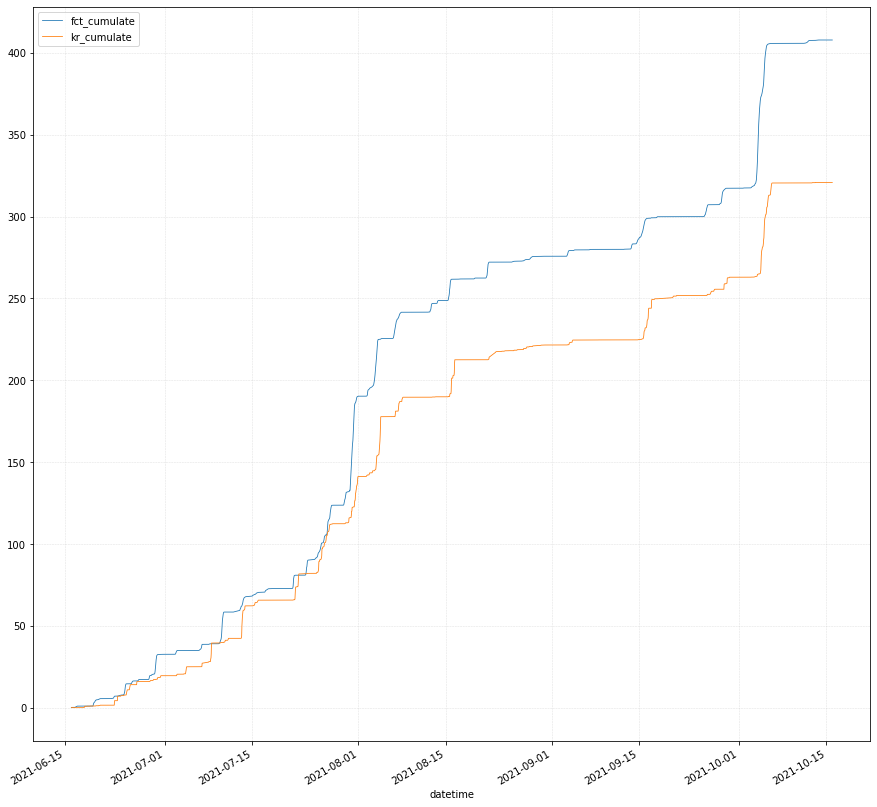

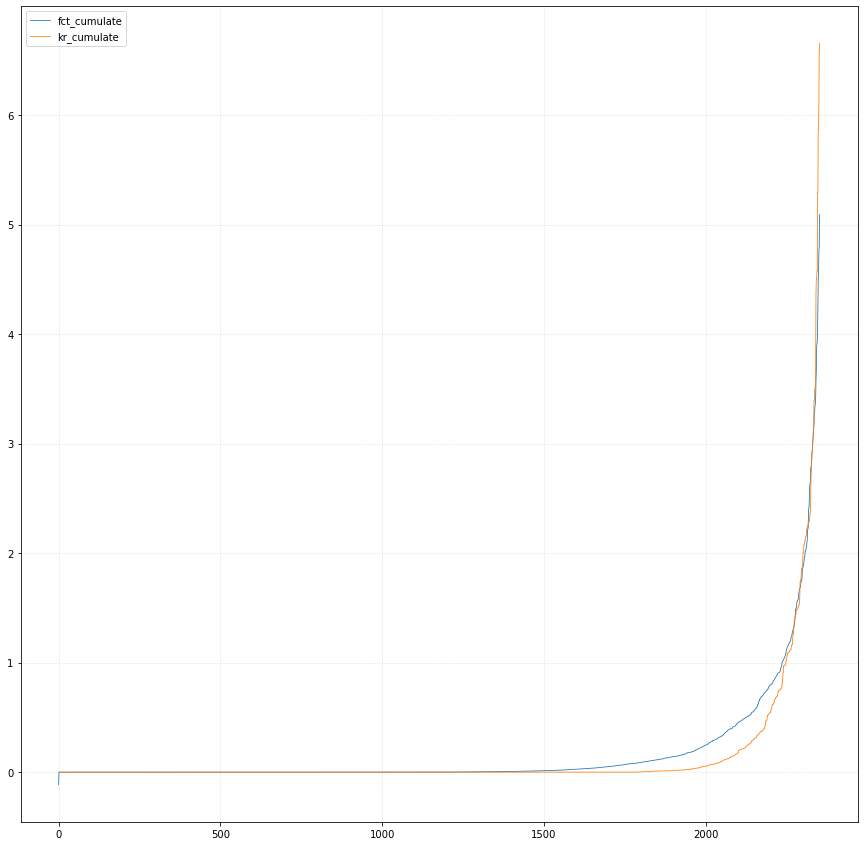

In [38]:
# cumulative PRECIPITATION
ordered_cumulate_df = pd.DataFrame(columns=['fct_cumulate', 'kr_cumulate'])
cumulate_df = pd.DataFrame(index=precipitation_data_kr_cut.index, columns=[
                           'fct_cumulate', 'kr_cumulate'])

fct_intensity = []
kr_intensity = []

fct_cumulate = []
kr_cumulate = []

for date in cumulate_df.index:

    date_str = dt.datetime.strftime(date, '%Y%m%d')

    try:
        current_forecast_data = precipitation_data_fct.T[[date_str]]
    except KeyError as e:
        # print("Not forecasted day: " + date_str)
        cumulate_df = cumulate_df.drop(date)
        continue

    # array of all points data at this time and hour
    kr_array = []
    fct_array = []

    for point in current_forecast_data.index:
        # print(point)

        try:
            kr_array.append(precipitation_data_kr_cut.loc[dt.datetime.strftime(
                date + dt.timedelta(hours=date.hour), input_dt_format)][point])
            fct_array.append(current_forecast_data.loc[point][0][date.hour])
        except KeyError as e:
            continue

    # mean of all point values in the grid
    fct_intensity.append(np.mean(fct_array))
    kr_intensity.append(np.mean(kr_array))

    if len(fct_intensity) >= 2:
        fct_cumulate.append(round(
            fct_intensity[len(fct_intensity)-1] + fct_cumulate[len(fct_intensity)-2], 2))
        kr_cumulate.append(
            round(kr_intensity[len(kr_intensity)-1] + kr_cumulate[len(kr_intensity)-2], 2))
    else:
        fct_cumulate.append(round(fct_intensity[0], 2))
        kr_cumulate.append(round(kr_intensity[0], 2))

cumulate_df['fct_cumulate'] = fct_cumulate
cumulate_df['kr_cumulate'] = kr_cumulate

ordered_cumulate_df['fct_cumulate'] = np.sort(fct_intensity)
ordered_cumulate_df['kr_cumulate'] = np.sort(kr_intensity)

cumulate_df.plot(figsize=(15, 15))
ordered_cumulate_df.plot(figsize=(15, 15))

# ### evaluate the threshold to correct the wet days bias - this is WRONG!!!!!!!!!!!!!!!!!!!!!!!!!!!
id_firstnonzero = ordered_cumulate_df[ordered_cumulate_df['kr_cumulate'] > 0].index[0] - 1
wetdays_threshold = ordered_cumulate_df.iloc[id_firstnonzero][ 'fct_cumulate' ]

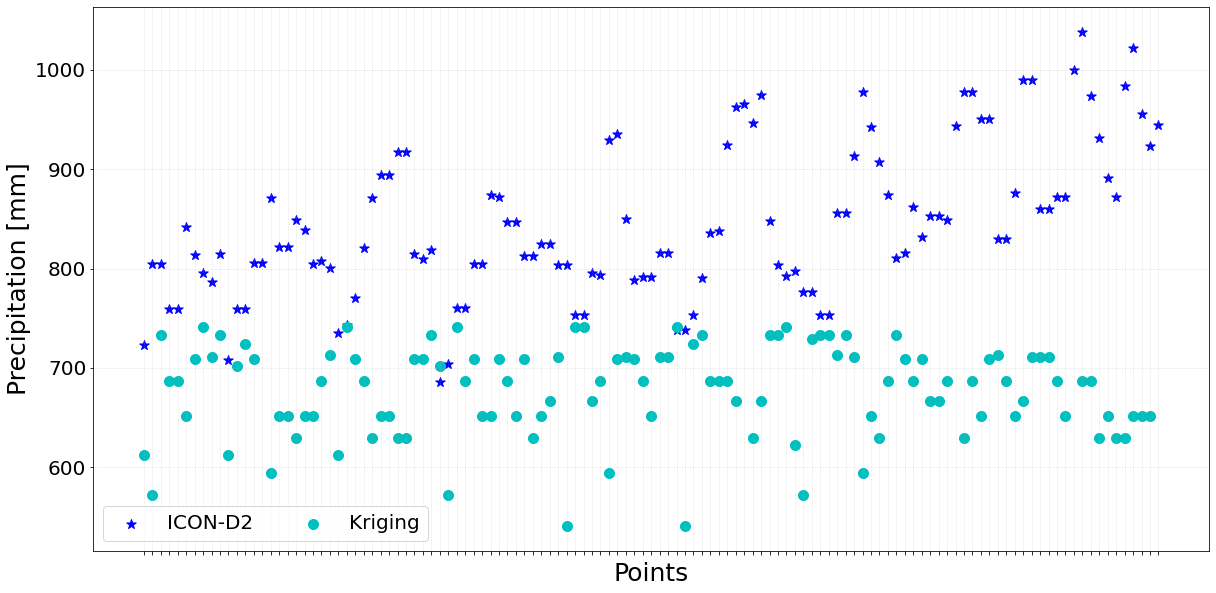

In [53]:
### analysis on wet days ###

precipitation_threshold = 0.00001
# prec_fct_threshold = 0.02
prec_fct_threshold = 0.00001

####################################
#### forecast data #################
precipitation_wet_fct = pd.DataFrame(
    index=precipitation_data_fct.index, columns=precipitation_data_fct.columns)

for c in precipitation_data_fct.columns:
    # print(c)

    wet_daily = []
    for point in precipitation_data_fct.index:
        # print(point)

        wet_daily.append(
            len([1 for i in precipitation_data_fct.loc[point][c] if i > prec_fct_threshold]))

    precipitation_wet_fct[c] = wet_daily

precipitation_wet_fct_df = pd.DataFrame(
    precipitation_wet_fct.sum(axis=0), columns=['values'])
precipitation_wet_fct_df.index.name = 'points'

####################################
#### observed data from KRIGING ####
precipitation_wet_kr_df = pd.DataFrame(
    index=precipitation_wet_fct_df.index, columns=['values'])

precipitation_data_kr_cut = precipitation_data_kr[start_date_str:end_date_str]

for point in precipitation_data_kr_cut.columns:
    # print(len(precipitation_data_kr_cut[point].values))
    precipitation_wet_kr_df.loc[point] = len(
        [1 for i in precipitation_data_kr_cut[point].values if i >= precipitation_threshold])

precipitation_wet_kr_df.index.name = 'points'

######################################
wet_hours_df = pd.merge(precipitation_wet_fct_df.reset_index(
), precipitation_wet_kr_df.reset_index(), on='points')
wet_hours_df = wet_hours_df.rename(
    columns={'values_x': 'fct', 'values_y': 'kr'})

wet_hours_df['bias_wet_days'] = wet_hours_df['fct'].values - \
    wet_hours_df['kr'].values

try:
    wet_hours_df = wet_hours_df.reset_index()
except:
    wet_hours_df = wet_hours_df

# Assuming wet_hours_df is your DataFrame and the necessary data is already loaded
colors = ['b', 'c', 'y', 'm', 'r']

# Scatter plots with your specified markers and colors
fct = plt.scatter(wet_hours_df['points'],
                  wet_hours_df['fct'], marker='*', color=colors[0], s=100)
kr = plt.scatter(wet_hours_df['points'],
                 wet_hours_df['kr'], marker='o', color=colors[1], s=100)

# Set figure size
plt.gcf().set_size_inches(20, 10)

# Update font size for labels, ticks, and title
plt.xlabel('Points', fontsize=25)  # Update x-axis label
plt.ylabel('Precipitation [mm]', fontsize=25)  # Update y-axis label

# Update font size for ticks
plt.xticks(ticks=plt.gca().get_xticks(), labels=[''] * len(plt.gca().get_xticks()), fontsize=20)
plt.yticks(fontsize=20)

# Update the legend with larger font size
plt.legend((fct, kr),
           ('ICON-D2', 'Kriging'),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=20)

# Add grid and display the plot
plt.grid(True)

plt.savefig(output_path_iahr22 + 'elevation_vs_mae.png', bbox_inches='tight', pad_inches=0, dpi=500, format='png')  # Save with high resolution

plt.show()